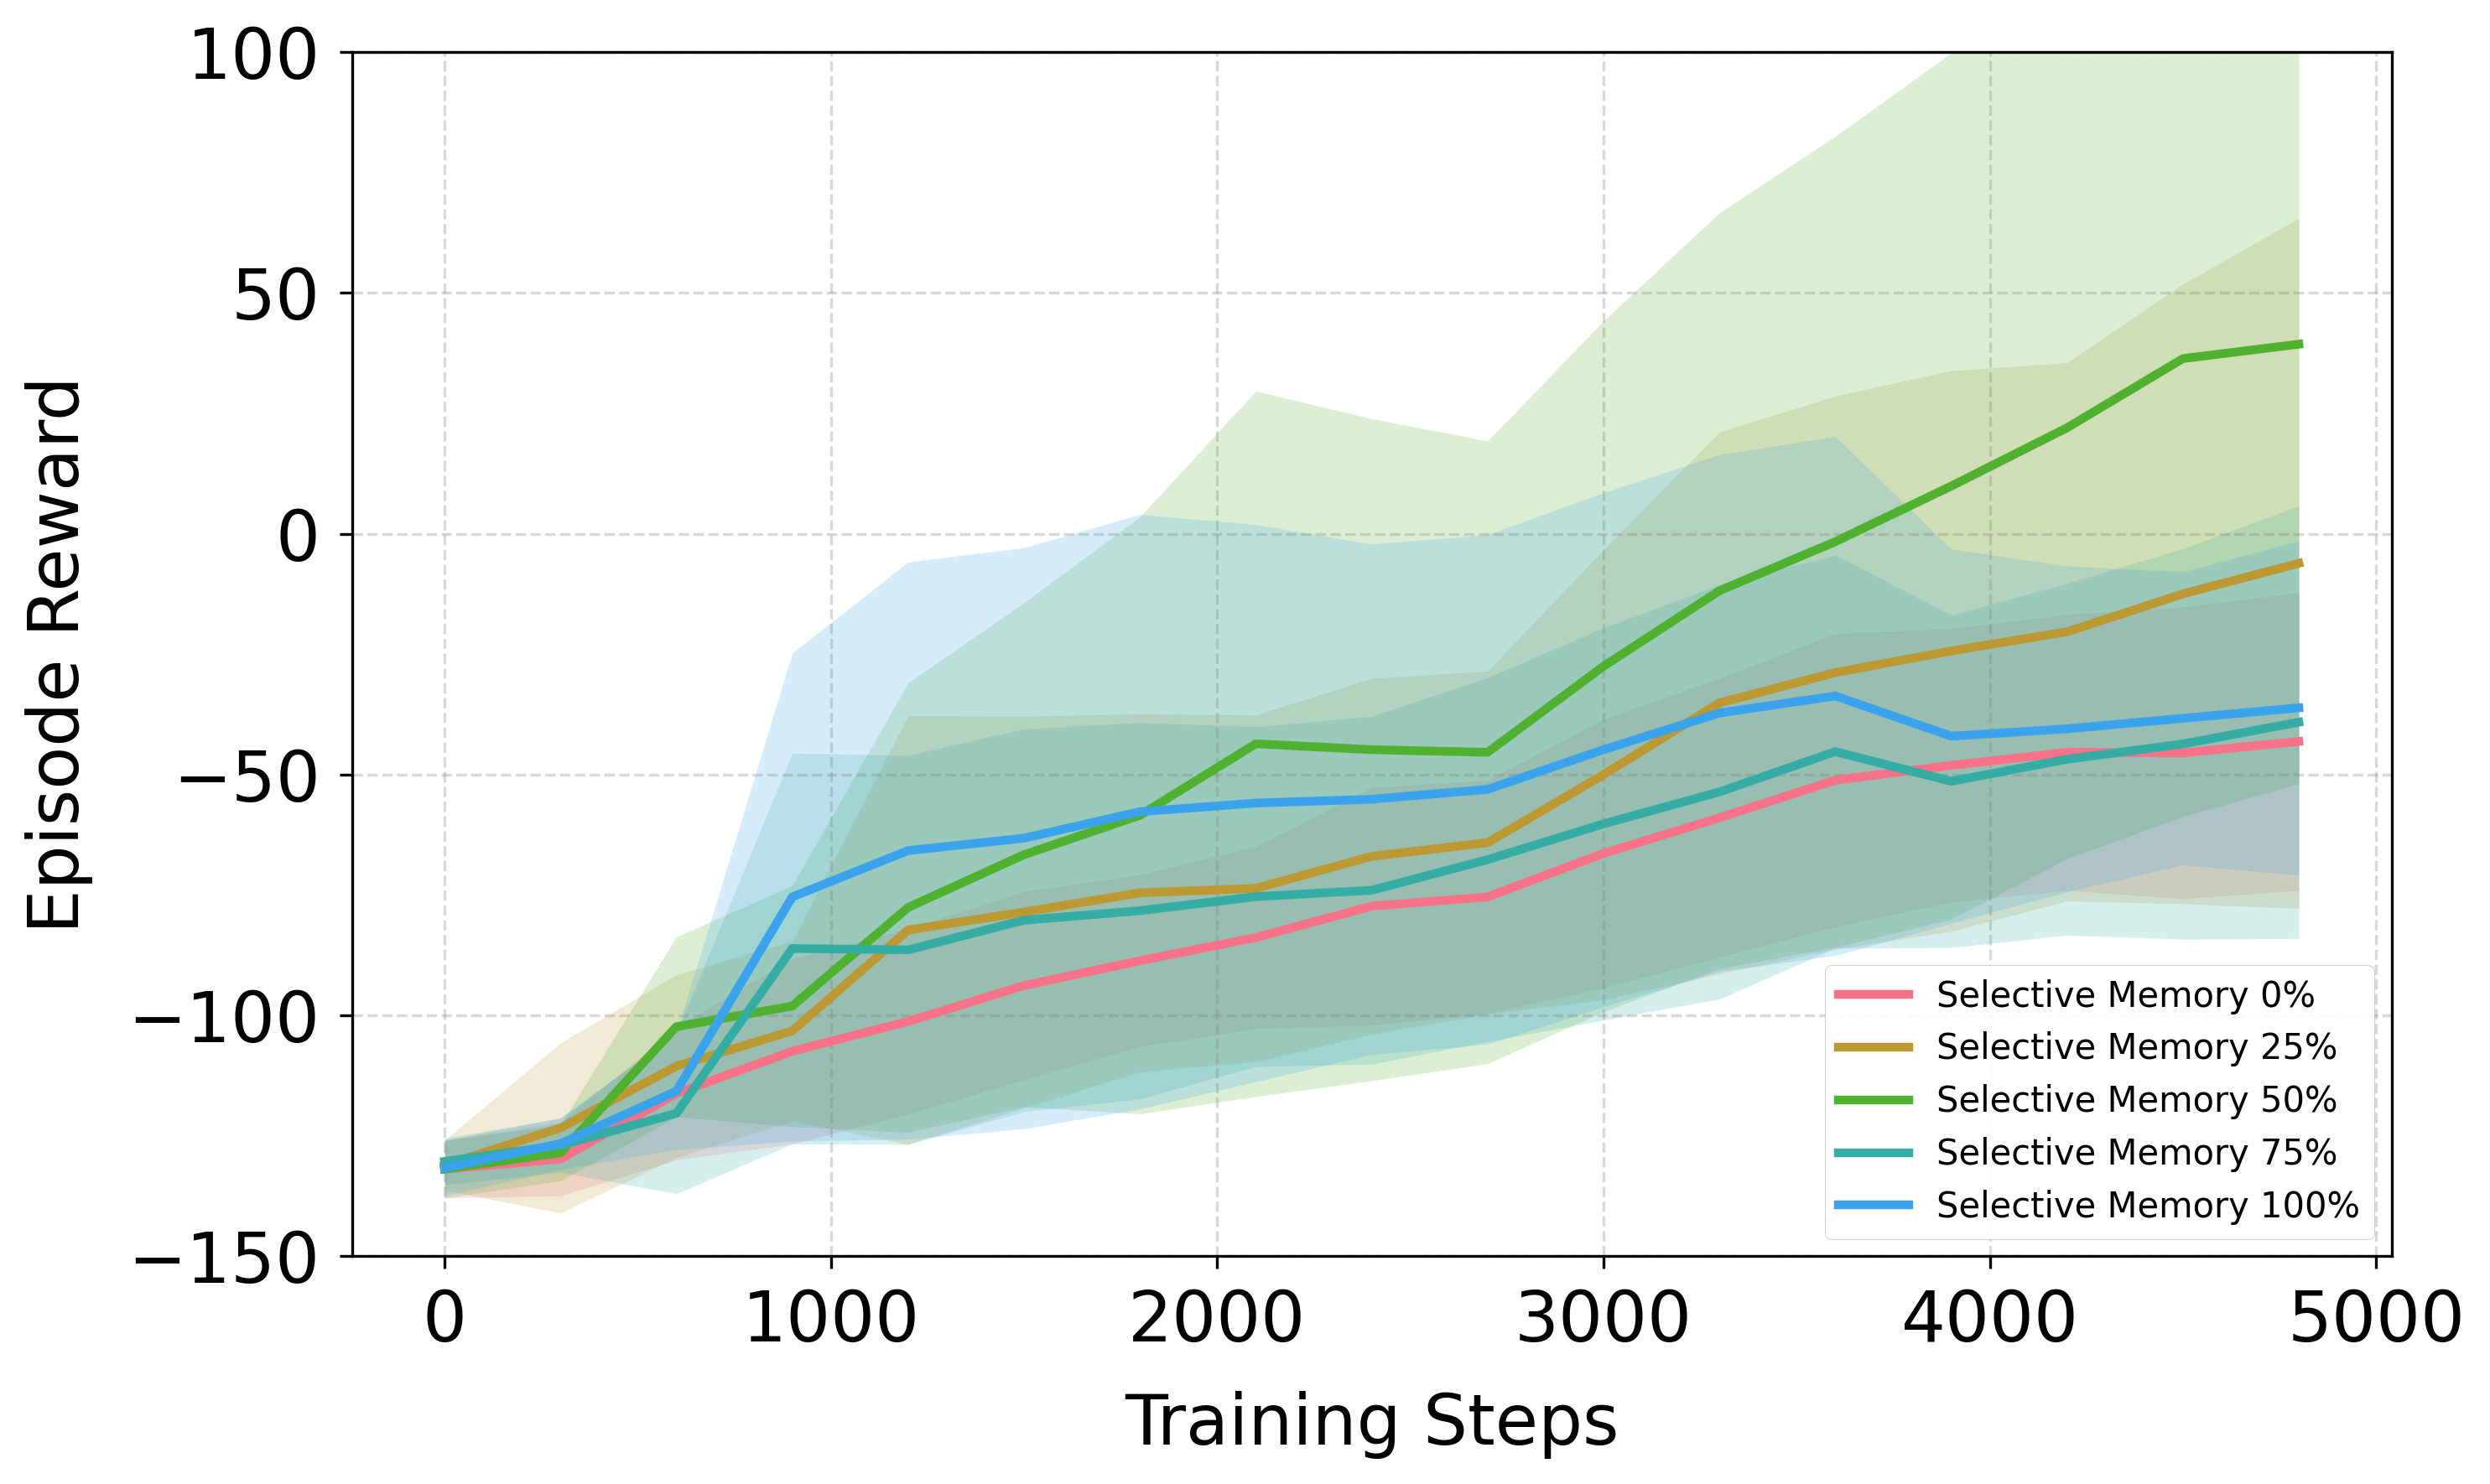

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

# Define task IDs and corresponding labels
task_ids = ['ptsd_00', 'ptsd_025', 'ptsd_05', 'ptsd_075', 'ptsd_1']
labels = ['Selective Memory 0%', 'Selective Memory 25%', 'Selective Memory 50%', 'Selective Memory 75%', 'Selective Memory 100%']
seeds = [520, 5200, 5211, 4567,123]

# Create figure
plt.figure(figsize=(10, 6), dpi=300)

# Set pure white background
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Plot for each task
for task_id, label in zip(task_ids, labels):
    all_rewards = []
    all_steps = None
    
    # Read data for each seed
    for seed in seeds:
        df = pd.read_csv(f'logs/ptsd_task/{seed}/{task_id}/eval.csv')
        if all_steps is None:
            all_steps = df['step']
            
        # Ensure all reward sequences have the same length
        rewards = df['episode_reward'].values
        if len(rewards) > len(all_steps):
            rewards = rewards[:len(all_steps)]
        elif len(rewards) < len(all_steps):
            padding = np.full(len(all_steps) - len(rewards), rewards[-1])
            rewards = np.concatenate([rewards, padding])
            
        all_rewards.append(rewards)
    
    # Calculate mean and standard deviation
    all_rewards = np.array(all_rewards)
    avg_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)
    
    # Apply smoothing
    window_size = 10
    smoothed_rewards = pd.Series(avg_rewards).rolling(window=window_size, min_periods=1).mean()
    smoothed_std = pd.Series(std_rewards).rolling(window=window_size, min_periods=1).mean()
    
    # Plot main curve
    line = plt.plot(all_steps, smoothed_rewards, label=label, linewidth=2.5)
    color = line[0].get_color()
    
    # Add shaded area to show variance
    plt.fill_between(
        all_steps, 
        smoothed_rewards - smoothed_std, 
        smoothed_rewards + smoothed_std, 
        alpha=0.2, 
        color=color,
        linewidth=0
    )

# Set axes and labels
plt.xlabel('Training Steps', fontsize=20, labelpad=10)
plt.ylabel('Episode Reward', fontsize=20, labelpad=10)
plt.legend(fontsize=10, loc='lower right', framealpha=0.9)

# Set grid lines
plt.grid(True, linestyle='--', alpha=0.3, color='gray')

# Set axis range and ticks
plt.ylim(-150, 100)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)

# Adjust layout and save
plt.tight_layout()
plt.savefig('ptsd.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Performance Improvement Summary (last 30 episodes):
Reward: 285.33 → 291.07 (Absolute: +5.73, Relative: +2.01%)
Survival Rate: 0.47 → 0.70 (Absolute: +0.23, Relative: +50.00%)

Training Efficiency Summary:
Steps to reach 232.85 reward: Normal=4200, PER2=4200 (Improvement: 0.00%)
Steps to reach 0.56 survival rate: Normal=4200, PER2=6000 (Improvement: -50.00%)


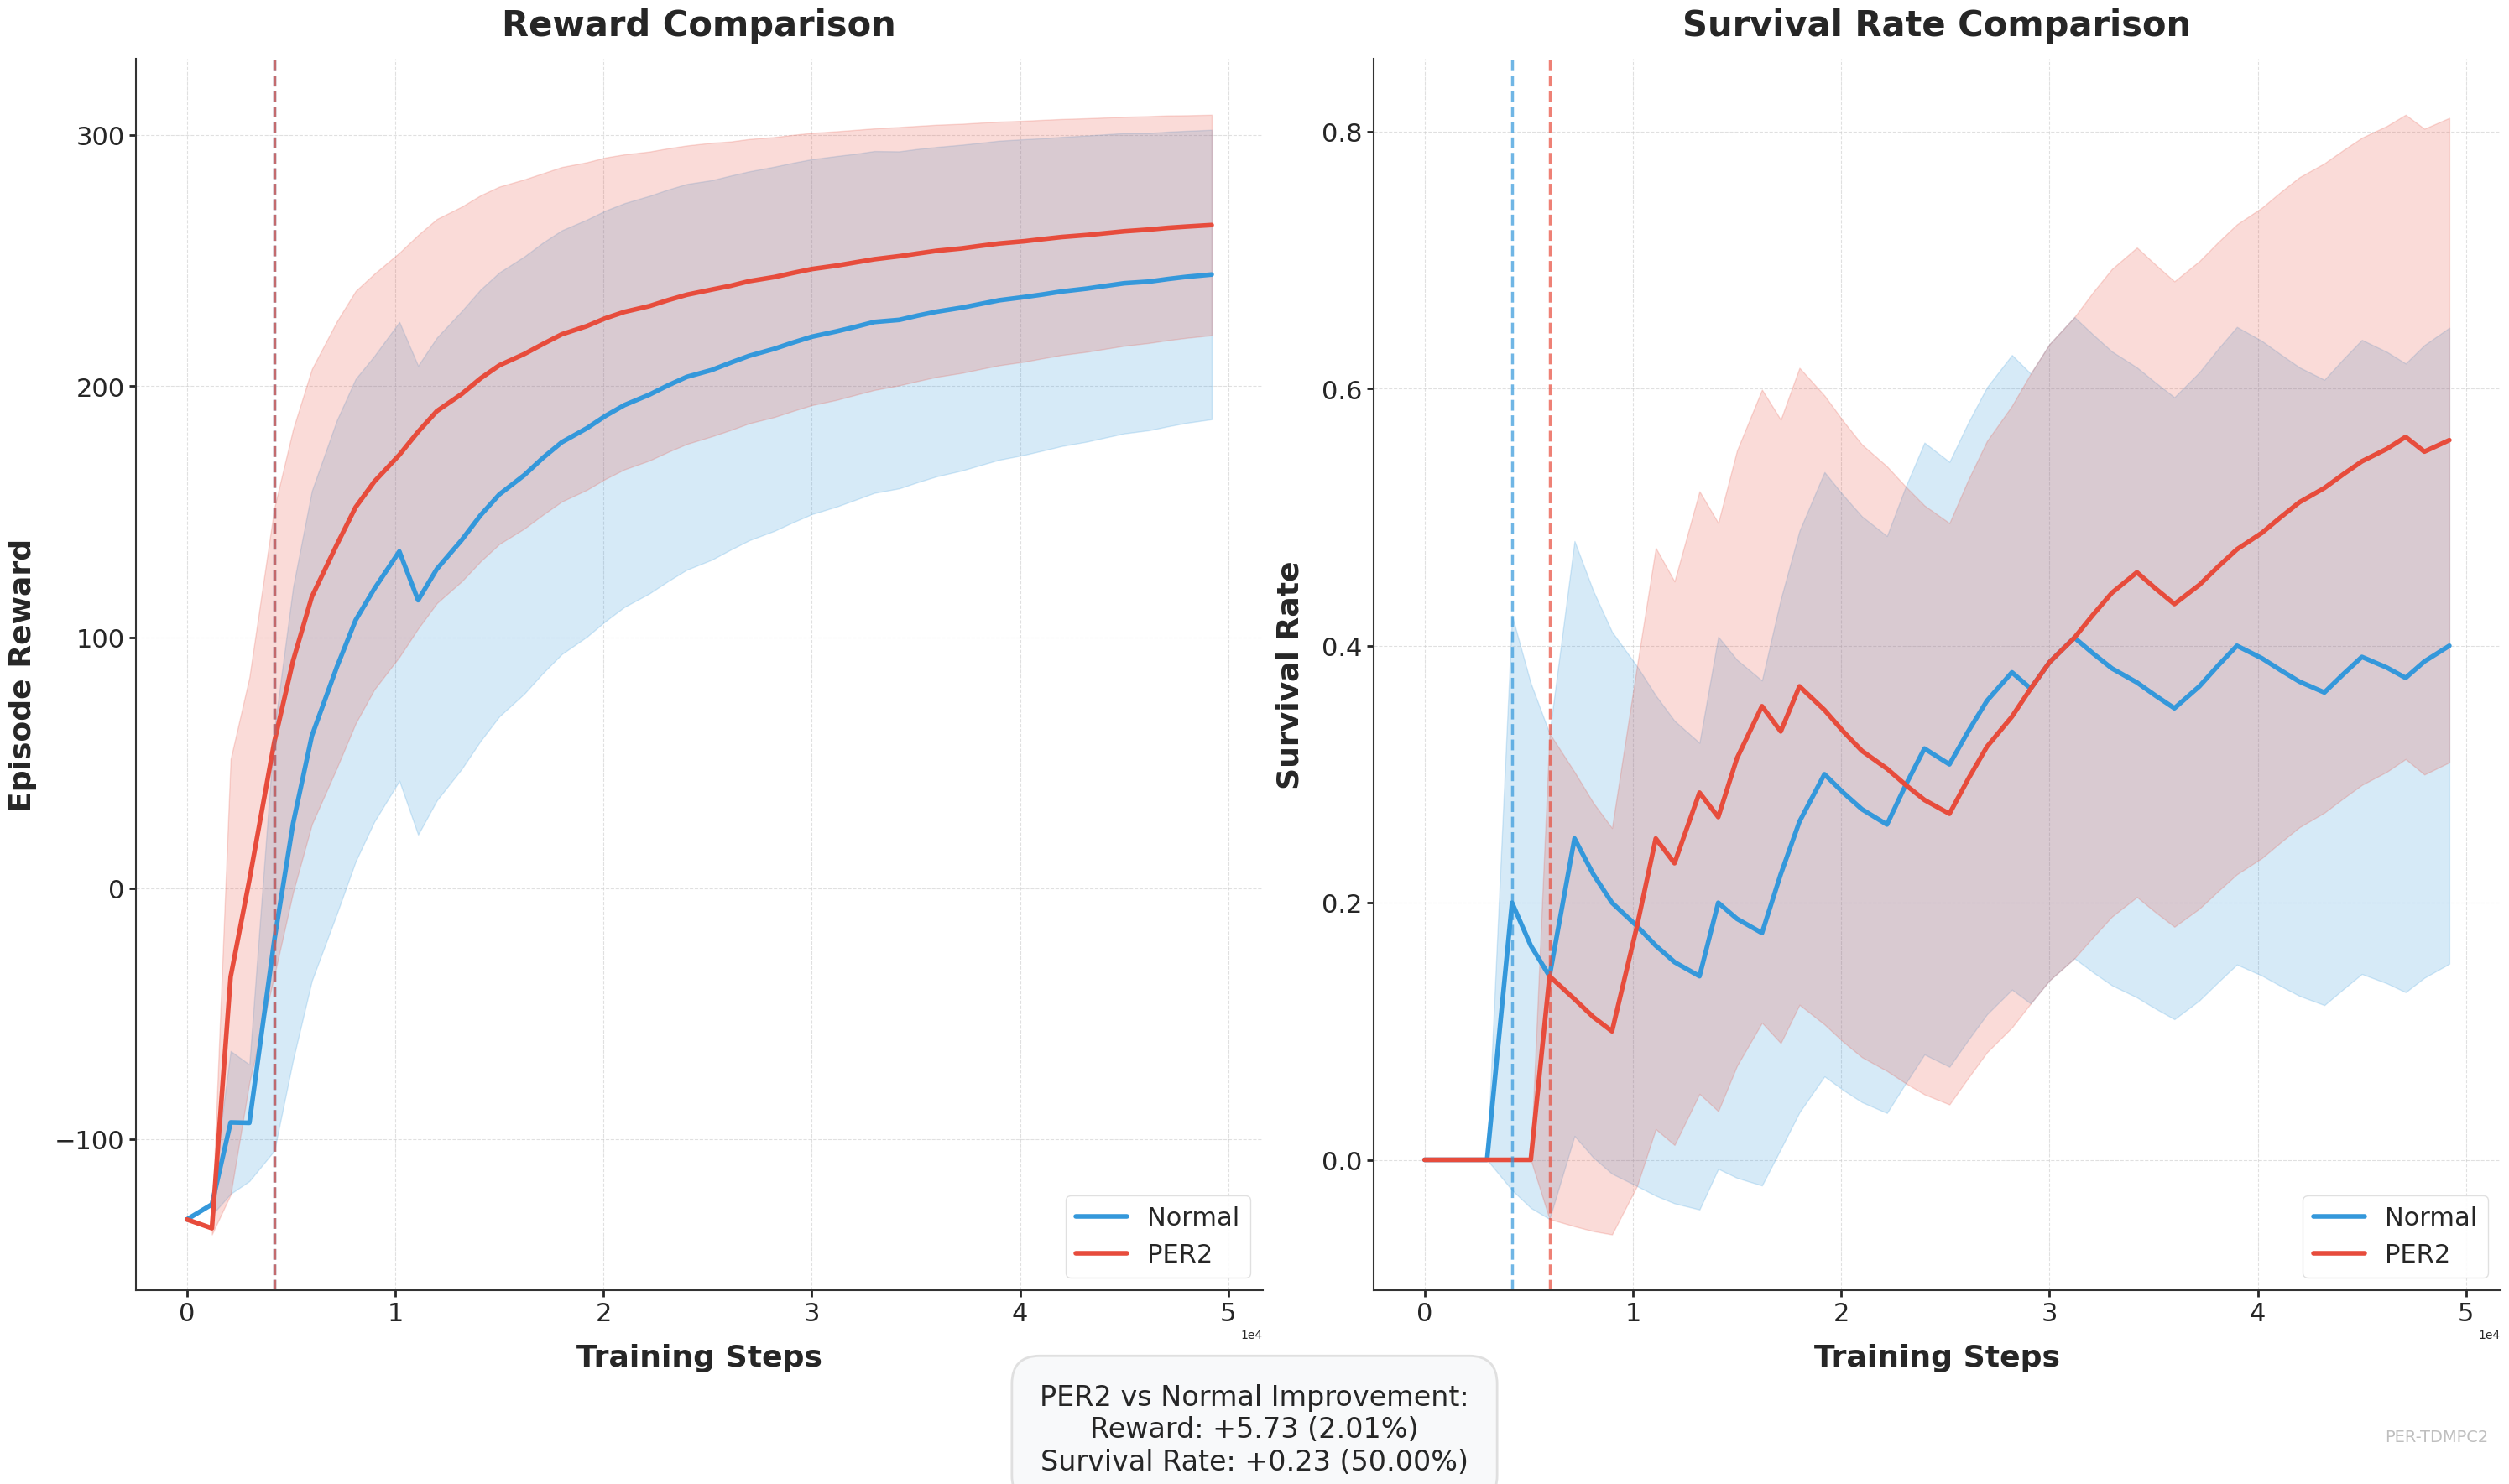

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set style for more beautiful plots
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['axes.edgecolor'] = '#333333'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5

# Define file paths
file1 = 'logs/per/123/normal/eval.csv'
file2 = 'logs/per/123/per2/eval.csv'
labels = ['Normal', 'PER2']
colors = ['#3498db', '#e74c3c']  # Nice blue and red colors

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 18), dpi=100, facecolor='white')
fig.patch.set_alpha(1.0)

# Dictionary to store data for analysis
data = {}

# Process each file
for i, (file_path, label) in enumerate(zip([file1, file2], labels)):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Get data
    steps = df['step']
    rewards = df['episode_reward']
    survival_rates = df['survival_rate']
    
    # Store data for analysis
    data[label] = {
        'steps': steps,
        'rewards': rewards,
        'survival_rates': survival_rates
    }
    
    # Apply smoothing
    window_size = 50
    smoothed_rewards = pd.Series(rewards).rolling(window=window_size, min_periods=1).mean()
    smoothed_survival = pd.Series(survival_rates).rolling(window=window_size, min_periods=1).mean()
    
    # Plot reward on the first subplot with shadow for uncertainty
    ax1.plot(steps, smoothed_rewards, label=label, linewidth=4.0, color=colors[i])
    ax1.fill_between(steps, 
                    smoothed_rewards - pd.Series(rewards).rolling(window=window_size, min_periods=1).std()*0.5,
                    smoothed_rewards + pd.Series(rewards).rolling(window=window_size, min_periods=1).std()*0.5,
                    color=colors[i], alpha=0.2)
    
    # Plot survival rate on the second subplot with shadow
    ax2.plot(steps, smoothed_survival, label=label, linewidth=4.0, color=colors[i])
    ax2.fill_between(steps, 
                    smoothed_survival - pd.Series(survival_rates).rolling(window=window_size, min_periods=1).std()*0.5,
                    smoothed_survival + pd.Series(survival_rates).rolling(window=window_size, min_periods=1).std()*0.5,
                    color=colors[i], alpha=0.2)

# Calculate improvement metrics
# For the last 30 episodes to get final performance
last_n = 30
normal_final_reward = data['Normal']['rewards'][-last_n:].mean()
per2_final_reward = data['PER2']['rewards'][-last_n:].mean()
reward_improvement_absolute = per2_final_reward - normal_final_reward
reward_improvement_percentage = (reward_improvement_absolute / abs(normal_final_reward)) * 100 if normal_final_reward != 0 else float('inf')

normal_final_survival = data['Normal']['survival_rates'][-last_n:].mean()
per2_final_survival = data['PER2']['survival_rates'][-last_n:].mean()
survival_improvement_absolute = per2_final_survival - normal_final_survival
survival_improvement_percentage = (survival_improvement_absolute / normal_final_survival) * 100 if normal_final_survival != 0 else float('inf')

# Analyze training efficiency - find steps needed to reach specific performance thresholds
def steps_to_threshold(data_series, threshold):
    for i, value in enumerate(data_series):
        if value >= threshold:
            return i
    return len(data_series)  # Return max steps if threshold never reached

# Define performance thresholds (e.g., 80% of final performance)
reward_threshold = 0.8 * per2_final_reward
survival_threshold = 0.8 * per2_final_survival

# Calculate steps needed to reach thresholds
normal_reward_steps = steps_to_threshold(data['Normal']['rewards'], reward_threshold)
per2_reward_steps = steps_to_threshold(data['PER2']['rewards'], reward_threshold)
normal_survival_steps = steps_to_threshold(data['Normal']['survival_rates'], survival_threshold)
per2_survival_steps = steps_to_threshold(data['PER2']['survival_rates'], survival_threshold)

# Calculate efficiency improvement
reward_efficiency_improvement = (1 - per2_reward_steps / normal_reward_steps) * 100 if normal_reward_steps > 0 else float('inf')
survival_efficiency_improvement = (1 - per2_survival_steps / normal_survival_steps) * 100 if normal_survival_steps > 0 else float('inf')

# Print improvement summary
print(f"Performance Improvement Summary (last {last_n} episodes):")
print(f"Reward: {normal_final_reward:.2f} → {per2_final_reward:.2f} (Absolute: +{reward_improvement_absolute:.2f}, Relative: +{reward_improvement_percentage:.2f}%)")
print(f"Survival Rate: {normal_final_survival:.2f} → {per2_final_survival:.2f} (Absolute: +{survival_improvement_absolute:.2f}, Relative: +{survival_improvement_percentage:.2f}%)")

# Print efficiency summary
print(f"\nTraining Efficiency Summary:")
print(f"Steps to reach {reward_threshold:.2f} reward: Normal={data['Normal']['steps'][normal_reward_steps]:.0f}, PER2={data['PER2']['steps'][per2_reward_steps]:.0f} (Improvement: {reward_efficiency_improvement:.2f}%)")
print(f"Steps to reach {survival_threshold:.2f} survival rate: Normal={data['Normal']['steps'][normal_survival_steps]:.0f}, PER2={data['PER2']['steps'][per2_survival_steps]:.0f} (Improvement: {survival_efficiency_improvement:.2f}%)")

# Mark thresholds on plots with elegant vertical lines
if normal_reward_steps < len(data['Normal']['steps']):
    ax1.axvline(x=data['Normal']['steps'][normal_reward_steps], color=colors[0], linestyle='--', alpha=0.7, linewidth=2.5)
if per2_reward_steps < len(data['PER2']['steps']):
    ax1.axvline(x=data['PER2']['steps'][per2_reward_steps], color=colors[1], linestyle='--', alpha=0.7, linewidth=2.5)
if normal_survival_steps < len(data['Normal']['steps']):
    ax2.axvline(x=data['Normal']['steps'][normal_survival_steps], color=colors[0], linestyle='--', alpha=0.7, linewidth=2.5)
if per2_survival_steps < len(data['PER2']['steps']):
    ax2.axvline(x=data['PER2']['steps'][per2_survival_steps], color=colors[1], linestyle='--', alpha=0.7, linewidth=2.5)

# Configure the first subplot (Reward)
ax1.set_xlabel('Training Steps', fontsize=26, labelpad=15, fontweight='bold')
ax1.set_ylabel('Episode Reward', fontsize=26, labelpad=15, fontweight='bold')
ax1.set_title('Reward Comparison', fontsize=30, fontweight='bold', pad=20)
ax1.legend(fontsize=22, frameon=True, facecolor='white', framealpha=0.9, edgecolor='#dddddd')
ax1.grid(True, linestyle='--', alpha=0.6, linewidth=0.8)
ax1.tick_params(axis='both', which='major', labelsize=22, width=2, length=6)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Configure the second subplot (Survival Rate)
ax2.set_xlabel('Training Steps', fontsize=26, labelpad=15, fontweight='bold')
ax2.set_ylabel('Survival Rate', fontsize=26, labelpad=15, fontweight='bold')
ax2.set_title('Survival Rate Comparison', fontsize=30, fontweight='bold', pad=20)
ax2.legend(fontsize=22, frameon=True, facecolor='white', framealpha=0.9, edgecolor='#dddddd')
ax2.grid(True, linestyle='--', alpha=0.6, linewidth=0.8)
ax2.tick_params(axis='both', which='major', labelsize=22, width=2, length=6)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add improvement text to the plot with a nicer box
improvement_text = (
    f"PER2 vs Normal Improvement:\n"
    f"Reward: +{reward_improvement_absolute:.2f} ({reward_improvement_percentage:.2f}%)\n"
    f"Survival Rate: +{survival_improvement_absolute:.2f} ({survival_improvement_percentage:.2f}%)"
)

# Add a text box for the improvement summary
fig.text(0.5, 0.02, improvement_text, ha='center', va='center', fontsize=24, 
         bbox=dict(boxstyle='round,pad=1', facecolor='#f8f9fa', alpha=0.9, 
                  edgecolor='#dddddd', linewidth=2))

# Add a subtle watermark
fig.text(0.99, 0.01, 'PER-TDMPC2', fontsize=14, color='gray', ha='right', va='bottom', alpha=0.5)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.97])  # Make room for the text at the bottom

# Save the figure with high quality
plt.savefig('normal_vs_per2_efficiency_comparison.pdf', dpi=300, bbox_inches='tight', 
           facecolor=fig.get_facecolor(), edgecolor='none')
plt.savefig('normal_vs_per2_efficiency_comparison.png', dpi=300, bbox_inches='tight', 
           facecolor=fig.get_facecolor(), edgecolor='none')

plt.show()